# ruiyi data structure

a notebook to play with ruiyi's data structure

## basic preparetion

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])

In [4]:
sys.path.append(os.path.abspath(workdir))
sys.path.append(os.path.abspath(workdir/'test'))
# os.chdir(workdir/'test/neural')
os.chdir(workdir)

In [5]:
# imports

from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.behav_class import *
from scipy.io import loadmat
import pickle
import pandas as pd
from numpy.lib.npyio import save
from cmaes import CMA
import matplotlib.pyplot as plt
from InverseFuncs import *
from monkey_functions import *
from notification import notify
from sklearn import linear_model
from plot_ult import *
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr,ttest_ind, sem, bootstrap
from pingouin import partial_corr
from scipy.ndimage import gaussian_filter1d

## setting some constants

In [6]:
# const

bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}

m = 'm53'
locals().update({m: {}})

figure_path = resdir/'figures'



In [7]:
# helper functions

def last_nonnan(arr, index=True):
    ''' return the last non nan number of a 1d array
    index: wheter to return index instead of number'''
    if index:
        return len(arr) - np.isnan(arr)[::-1].argmax() - 1
    return arr[len(arr) - np.isnan(arr)[::-1].argmax() - 1]

def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
       
        
def downsample(data, bin_size=20):
    num_bin = data.shape[0] // bin_size
    data_ = data[:bin_size * num_bin]
    data_ = data_.reshape(num_bin, bin_size, data.shape[-1])
    data_ = np.nanmean(data_, axis=1)
    return data_


def convert_location_to_relative(
        mx,
        my,
        body_theta,
        x_fly,
        y_fly,
        dt=0.1

):
    '''
        calculate relative beliefs and states
    '''

    x_fly_rel = x_fly - mx
    y_fly_rel = y_fly - my
    phi = body_theta.reshape(-1)
    R = lambda theta : np.array([[np.cos(theta/180*np.pi),-np.sin(theta/180*np.pi)],[np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)]])
    XY = np.zeros((2,x_fly_rel.shape[0]))
    XY[0,:] = x_fly_rel.reshape(-1)
    XY[1,:] = y_fly_rel.reshape(-1)
    rot = R(phi)
    XY = np.einsum('ijk,jk->ik', rot, XY)
    xfp_rel= XY[0, :]
    yfp_rel = XY[1, :]
    
    return xfp_rel,yfp_rel




def convert_location_to_angle(gaze_r, gaze_x, gaze_y, body_theta, body_x, body_y, hor_theta_eye, ver_theta_eye,DT=DT, remove_pre=True):
    '''
        convert the world overhead view location of the 'gaze' location to eye coord. 

        gaze location, the target
        gaze_r, relative distance
        gaze_x, gaze location x
        gaze_y,

        body_theta, heading direction
        body_x, monkey location x
        body_y, 

        hor_theta_eye, actual eye location in eye coord. used here to remove pre saccade (when monkey hasnt seen the target yet)
        ver_theta_eye
    '''

    #hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), gaze_y - body_y) - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), np.sqrt((gaze_y - body_y)**2 + monkey_height**2))
                            - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    overshoot_idx = np.where(((gaze_x - body_x) * gaze_x < 0) | (gaze_y < body_y)
                             #| (abs(hor_theta.flatten()) > 60)
                            )[0]
    
    if overshoot_idx.size > 0:
        hor_theta[overshoot_idx[0]:] = np.nan

    k = -1 / np.tan(body_theta); b = body_y - k * body_x
    gaze_r_sign = (k * gaze_x + b < gaze_y).astype(int)
    gaze_r_sign[gaze_r_sign == 0] = -1
    ver_theta = -np.rad2deg(np.arctan2(monkey_height, gaze_r_sign * gaze_r)).reshape(-1, 1)
    overshoot_idx = np.where((gaze_r_sign < 0)
                             #| (abs(ver_theta.flatten()) > 60)
                            )[0]
    if overshoot_idx.size > 0:
        ver_theta[overshoot_idx[0]:] = np.nan
        
    # detect saccade
    if remove_pre:
        if hor_theta_eye.size > 2:
            saccade = np.sqrt((np.gradient(hor_theta_eye) / DT)**2 + 
                            (np.gradient(ver_theta_eye) / DT)**2)
            saccade_start_idx = np.where(saccade > 100)[0]
            saccade_start_idx = saccade_start_idx[0] + 16 if saccade_start_idx.size > 0 else None

            hor_theta[:saccade_start_idx] = np.nan
            ver_theta[:saccade_start_idx] = np.nan
        
    return hor_theta, ver_theta


def compute_error(data1, data2, mask):
    #data1 = data1[~mask]; data2 = data2[~mask]
    #corr = np.corrcoef(data1, data2)
    error = abs(data1 - data2)
    
    rng = np.random.default_rng(seed=0)
    data1_ = data1.copy(); data2_ = data2.copy()
    rng.shuffle(data1_); rng.shuffle(data2_)
    error_shuffle = abs(data1_ - data2_)
    return error


# helper functions

def compute_corr(data1, data2, mask=None):
    '''compute the correlation coeef of two data'''
    if mask is not None:
        data1 = data1[~mask]; data2 = data2[~mask]
    corr = np.corrcoef(data1, data2)
    return abs(corr[0, 1])
def compute_partial_corr(data1, data2, data3, mask=None):
    '''compute the correlation of d1 and d2 while controling d3'''
    if mask is not None:
        data1 = data1[~mask]; data2 = data2[~mask]; data3 = data3[~mask]    
    df = pd.DataFrame({'d1': data1, 'd2': data2, 'd3': data3})
    corr_partial = partial_corr(data=df, x='d1', y='d2', covar='d3')['r'].item()
    return abs(corr_partial)

def shuffle_decoder(seed):
    kf = KFold(n_splits=5)
    decoded_target_idx = [4, 5, 6, 7]
    m_decoders = {}
    for area in areas:  # loop areas
        decoders_session = {}
        for key in eval(m).keys():  # loop sessions
            if key[-1].isalpha():
                continue

            X = eval(m)[key + 'Xdownsampled'][area]
            if len(X) == 0:
                continue
            Y = eval(m)[key + 'Ydownsampled_belief']
            trial_idces, X = zip(*X)
            trial_idces, Y = zip(*Y); trial_idces = np.array(trial_idces)

            model_variable = []
            for idx_variable in decoded_target_idx:  # loop target variable
                model_kfold = []
                for train_trial_idx, test_trial_idx in kf.split(trial_idces):  # loop K fold
                    X_train = np.concatenate([X[i] for i in train_trial_idx]) 
                    X_test = np.concatenate([X[i] for i in test_trial_idx])
                    Y_train = np.concatenate([Y[i] for i in train_trial_idx])
                    Y_test = np.concatenate([Y[i] for i in test_trial_idx])

                    train_mask = ~np.isnan(Y_train[:, idx_variable])
                    test_mask = ~np.isnan(Y_test[:, idx_variable])

                    #shuffle
                    rng = np.random.default_rng(seed=seed)
                    shifts = rng.integers(1, X_train.shape[0], size=X_train.shape[1])
                    for i, shift in enumerate(shifts):
                        X_train[:, i] = np.roll(X_train[:, i], shift=shift)

                    pipe = make_pipeline(StandardScaler(), RidgeCV())
                    pipe.fit(X_train[train_mask], Y_train[train_mask, idx_variable])

                    model_kfold.append([test_trial_idx, trial_idces[test_trial_idx], pipe])

                model_variable.append(model_kfold)
            decoders_session[key] = model_variable
        m_decoders[area + 'decoder'] = decoders_session


    m_score_t = {}
    for area in areas:
        scores_error_session_by_trial = {}
        for key in eval(m).keys():
            if key[-1].isalpha():
                continue

            Xt = eval(m)[key + 'Xt'][area]
            if len(Xt[0]) == 0:
                continue
            Yt = eval(m)[key + 'Yt']
            scores_trial = []

            for t in range(num_bins):
                trial_idces, X = zip(*Xt[t])
                X = np.vstack(X)
                trial_idces, Y = zip(*Yt[t])
                Y = np.vstack(Y)

                # decoding
                score_trial = []
                for idx_variable_enu, idx_variable in enumerate(decoded_target_idx):
                    Y_ = Y[:, idx_variable]
                    score_trial_ = []
                    for kfold_trial_indices, kfold_trial_relindices, kfold_decoder in \
                                                                        m_decoders[area + 'decoder'][key][idx_variable_enu]:
                        # decoding error for each trial
                        for trial_idx_enu, trial_idx in enumerate(trial_idces):
                            if trial_idx not in kfold_trial_relindices:
                                continue
                            score_trial_.append([trial_idx, t, 
                                                 kfold_decoder.predict(X[trial_idx_enu:trial_idx_enu+1])[0], 
                                                 Y_[trial_idx_enu:trial_idx_enu+1][0]])

                    score_trial.append(score_trial_)
                scores_trial.append(np.array(score_trial))  
            scores_error_session_by_trial[key] = np.concatenate(scores_trial, axis=1).swapaxes(0, 2)
        m_score_t[area + 'decoding_error_trial'] = scores_error_session_by_trial
    return m_score_t



def eye2world(eh, ev, height=10,screen_dist=32.5, removenan=False):
    '''   
        convert the eye coord to world coord.
        eh, eye horizontal angle
        ev, eye verticle angle.

        output(forward, lateral) is the relative position in world coord
    '''
    eh,ev=np.deg2rad(eh), np.deg2rad(-ev)
    # distance=height/np.tan(ev)
    # forward=(distance**2-height**2)**0.5
    # lateral=(height**2+forward**2)**0.5 * np.tan(eh)
    
    # lateral = np.sqrt((np.tan(eh)**2 * (height**2 + 1)))
    # forward= (np.tan(ev)**2 / (height**2 * np.tan(eh)**2 - 1)) / np.sqrt(np.tan(eh)**2 + 1) * height
    
    forward=np.sqrt((height**2-np.tan(eh)**2*np.tan(ev)**2*height**2)/(np.tan(eh)**2*np.tan(ev)**2+np.tan(ev)**2))
    lateral=np.tan(eh)*np.sqrt(height**2+forward**2)

    if removenan:
        invalididx= (forward<screen_dist) & (np.isinf(forward)) &(np.isinf(lateral))
        forward[invalididx] = np.nan
        lateral[invalididx] = np.nan
        
    return forward, lateral

# load data


- neural: # trial* time * unit
- Xt: # area, bin, [trial index, actvity]
- Xdownsampled: area, trial_index, activity
- Yt: bin, trial, [trial index, actvity array (ts, dim)]
                [0123: rel_dist, rel_ang, abs_dist, abs_ang,  
                 45:  hor_theta, ver_theta (eye in eye)
                 67: hor_theta_, ver_theta_,  (true target in eye)
                 8901: fx, fy, mx, my  
                 23: relative lateral, relative forward,
                 ]
- Ydownsampled: trial, [trial index, actvity]
- trials_error: trial, 


In [8]:
# load data mat

datapaths = [resdir/'neuraltest/m53s31.mat'] # can have multi data files
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data

In [9]:
# load the irc belief
with open(resdir/'neuraltest/res/m53s31_0928newformatbelief', 'rb') as f:
    res = pickle.load(f)
irc_valid_trials=np.unique(res['trial_idx'])

In [10]:
# load raw neural  trial* time * unit 

m_neural = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    
    trials_neural = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)

        activities = []
        for trials_unit in trials_units:
            fire_ts = trials_unit['trials'][0][trial_idx][0].reshape(-1)
            if fire_ts.size > 0 and fire_ts[-1] >= trial_ts[-1]:
                fire_ts = fire_ts[:-1]
            activity = np.zeros_like(trial_ts)
            bin_indices = np.digitize(fire_ts, trial_ts)
            unique_bins, bin_counts = np.unique(bin_indices, return_counts=True)
            activity[unique_bins] = bin_counts
            activities.append(activity)

        activities = np.vstack(activities).T   # time * unit
        activities = gaussian_filter1d(activities, sigma=4, axis=0)
        trials_neural.append(activities)    
    m_neural[key + 'neural'] = trials_neural
    
eval(m).update(m_neural)
del m_neural

In [11]:
# load X(neural), Y(task var), downsampled, and basic behavior such as errors
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 
    Yt = [[] for _ in range(num_bins)]
    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        # pass the no belief trials
        if trial_idx not in irc_valid_trials:
            continue

        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        hor_theta_, ver_theta_ = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
                                                           body_theta, body_x, body_y, 
                                                           hor_theta.reshape(-1), ver_theta.reshape(-1))
        
        # calculate relative state (relative target location rotated by heading)
        rel_lat, rel_for=convert_location_to_relative(
                                mx,
                                my,
                                body_theta,
                                fx,
                                fy,
                                dt=0.1)
        
        
        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     hor_theta, ver_theta, 
                                     hor_theta_, ver_theta_,
                                     fx, fy, mx, my,
                                     rel_lat.reshape(-1,1), rel_for.reshape(-1,1)])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        
        # filter trials
        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1)
        #if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or abs_dist[-1] < 50 or \
        #   trial_behv['prs']['floordensity'] != 0.0001:
        
        # TODO load beleif and neural together and use this:
        # if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or abs_dist[-1] < 50:
        #     continue
                
        # for Yt
        Ydownsampled.append([trial_idx, target_variable])
        for bin_idx in range(num_bins):
            if target_variable.shape[0] > bin_idx:
                Yt[bin_idx].append([trial_idx, target_variable[bin_idx]])
                #Yt[bin_idx].append([trial_idx, target_variable[-(bin_idx+1)]])
                
        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])
      
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Xt'] = Xt; m_downsampled[key + 'Yt'] = Yt
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled
    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors)
del m_downsampled, m_extracted_continuous, m_errors

## load irc belief
shape belief into target variables, trial, [trial id, array]

In [90]:

# TODO need to fix the key for multi data runs
key=list(eval(m).keys())[0]
    
m_downsampled = {}; m_errors = {}
Ydownsampled = []  # belief task variables
trials_error = []
trials_error_sign = []
trials_target_angle = []
trials_target_distance = []

for itrial in np.unique(res['trial_idx']):

    # prepare to process time series belief into block per trial
    this_mask = (res['trial_idx'] == itrial)
    # print('belief',res['belief'][this_mask].shape)

    # get firefly position from raw data
    trial_behv = trials_behv[itrial]
    trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
    t_mask = (trial_ts > 0) & (
        ~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
    t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
    if t_mask.sum() > 0:
        # remove the first data point to avoid downsample error
        t_mask[np.where(t_mask == True)[0][0]] = False
    fx = downsample(trial_behv['continuous']['xfp']
                    [0][0][t_mask], bin_size=bin_size)
    fy = downsample(trial_behv['continuous']['yfp']
                    [0][0][t_mask], bin_size=bin_size)

    # unppack irc belief mu
    # world monkey x (belief)
    mx = res['belief'][this_mask][:, 0].reshape(-1, 1)
    my = res['belief'][this_mask][:, 1].reshape(-1, 1)
    body_theta = res['belief'][this_mask][:, 2].reshape(-1, 1)
    body_theta=np.deg2rad(body_theta + 90)
    mv = res['belief'][this_mask][:, 3]
    mw = res['belief'][this_mask][:, 4]

    # sometimes belief has one more dt due to sampling error. 
    # remove the first belief
    if len(fx) < len(mx):
        body_theta = body_theta[len(my)-len(fy):]
        mv = mv[len(my)-len(fy):]
        mw = mw[len(my)-len(fy):]
        mx = mx[len(mx)-len(fx):]
        my = my[len(my)-len(fy):]
    # continue the last belief 
    if len(fx) > len(mx):
        body_theta=np.vstack([body_theta,[body_theta[-1,:]]*(len(fy)-len(my))])
        mv=np.vstack([mv,[mv[-1,:]]*(len(fy)-len(my))])
        mw=np.vstack([mw,[mw[-1,:]]*(len(fy)-len(my))])
        mx=np.vstack([mx,[mx[-1,:]]*(len(fx)-len(mx))])
        my=np.vstack([my,[my[-1,:]]*(len(fy)-len(my))])


    # calculate errors (belief mu)
    sx = np.ones_like(fx)
    sy = np.ones_like(fy)
    if my.size > 0:
        fx = np.ones_like(fx) * fx[0]
        fy = np.ones_like(fy) * fy[0]
        sx *= mx[-1]
        sy *= my[-1]
        # my = my + 30
        my = my + 2.5
        fy = fy + 30
        sy = sy + 30

    dx = fx - mx
    dy = fy - my
    rel_dist = np.sqrt(dx**2 + dy**2)
    rel_ang = np.rad2deg(np.arctan2(dy, dx))
    rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)

    if my.size > 0:
        trials_error.append(rel_dist[-1][0])
        trials_error_sign.append(rel_dist[-1][0])
        trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
        trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])

    else:
        trials_error.append(np.nan)
        trials_error_sign.append(np.nan)
        trials_target_angle.append(np.nan)
        trials_target_distance.append(np.nan)

    if my.size > 0:
        d1 = np.sqrt(fx**2 + fy**2)
        r1 = (fx**2 + fy**2) / (2*fx)
        radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

        d2 = np.sqrt(mx**2 + my**2)
        r2 = (mx**2 + my**2) / (2*mx + 1e-8)
        radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

        sign = np.ones_like(rel_dist)
        sign[radian2 < radian1] = -1
        rel_dist = sign * rel_dist
        trials_error_sign[-1] = rel_dist[-1][0]
    abs_dist = np.sqrt(mx**2 + my**2)
    abs_ang = np.rad2deg(np.arctan2(my, mx))

    # calculate relative belief (relative target location rotated by heading)
    rel_lat, rel_for=convert_location_to_relative(
                            mx,
                            my,
                            body_theta,
                            fx,
                            fy,
                            dt=0.1)
    

    covs=res['covs'][this_mask]
    rotdegree=body_theta+180
    relativeposcov=[]
    for degree, thiscov in zip(rotdegree, covs):
        R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
        relativeposcov.append(R.T@thiscov[:2,:2]@R)
    relativeposcov=np.stack(relativeposcov)[:,:,:,0]
    

    # calculate the latent ff position
    body_x, body_y = mx.reshape(-1), my.reshape(-1)
    hor_theta = downsample(trial_behv['continuous']['yre']
                           [0][0][t_mask], bin_size=bin_size)
    ver_theta = downsample(trial_behv['continuous']['zre']
                           [0][0][t_mask], bin_size=bin_size)
    
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
                        body_theta.reshape(-1), body_x, body_y,
                        hor_theta.reshape(-1), ver_theta.reshape(-1),DT=0.1, remove_pre=False)
    # remove the pre saccade part ?


    # group and save the variables
    target_variable = np.hstack([rel_dist,  # mk belief - target dist
                                 rel_ang,  # mk belief - target agnle
                                 abs_dist,  # mk belief - start dist
                                 abs_ang,
                                 
                                 hor_theta, ver_theta, # actual target in eye coord
                                 hor_theta_,  ver_theta_,  # mk belief target in eye coord
                                 rel_lat.reshape(-1,1), rel_for.reshape(-1,1), # mk belief target in ego centric world xy coord
                                 mx, my,  # mk belief xy 
                                body_theta,  # mk belief heading ,
                                mv.reshape(-1,1), mw.reshape(-1,1), 
                                relativeposcov[:,0,0].reshape(-1,1),relativeposcov[:,1,1].reshape(-1,1),relativeposcov[:,1,0].reshape(-1,1)# cov
                                ])
    
    Ydownsampled.append([itrial, target_variable])

m_downsampled[key + 'Ydownsampled_belief'] = Ydownsampled
m_errors[key + 'error_belief'] = trials_error; m_errors[key + 'error_sign_belief'] = trials_error_sign
m_errors[key + 'target_angle_belief'] = trials_target_angle; m_errors[key + 'target_distance_belief'] = trials_target_distance

# update the struct
eval(m).update(m_downsampled)
eval(m).update(m_errors)



# Analysis

## correlation numbers

state-eye has a stronger correlation than belief-eye, for now.

those corr numbers are hard to understand. need better visualization, eg, color the dots by some other task varialbes.

In [13]:
# some correlation numbers 

Y_=eval(m)['m53s31Ydownsampled']
B_=eval(m)['m53s31Ydownsampled_belief']
X_=eval(m)['m53s31Xdownsampled']['PPC']

len(X_), len(B_), len(Y_)

trial_idces, X = zip(*X_)
X = np.vstack(X)
trial_idces, Y = zip(*Y_)
Y = np.vstack(Y)
trial_idces, B = zip(*B_)
B = np.vstack(B)


mask = (~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression horizontal',np.mean(cross_val_score(LinearRegression(), Y[mask][:, [4]], Y[mask][:, 6])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [4]], B[mask][:, 6])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7]))
print('linear regression vertical', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [5]], Y[mask][:, 7])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [5]], B[mask][:, 7])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7])) &(~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression both', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [4,5]], Y[mask][:, [6,7]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [4,5]], B[mask][:, [6,7]])))



mask = (~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression horizontal',np.mean(cross_val_score(LinearRegression(), Y[mask][:, 6], Y[mask][:, [4]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, 6], B[mask][:, [4]])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7]))
print('linear regression vertical', np.mean(cross_val_score(LinearRegression(), Y[mask][:, 7], Y[mask][:, [5]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, 7], B[mask][:, [5]])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7])) &(~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression both', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [6,7]], Y[mask][:, [4,5]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [6,7]], B[mask][:, [4,5]])))



linear regression horizontal 0.3488763639362703 0.15801833067666243
linear regression vertical 0.09623288633479521 0.07929697962301589
linear regression both 0.3744588478303449 0.17638733020239689
linear regression horizontal nan nan
linear regression vertical nan nan
linear regression both 0.34795861498837305 0.16319530492905904


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


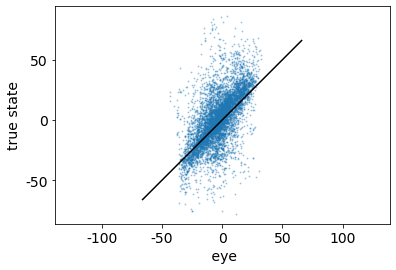

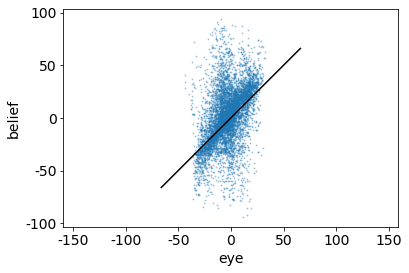

Text(0, 0.5, 'belief')

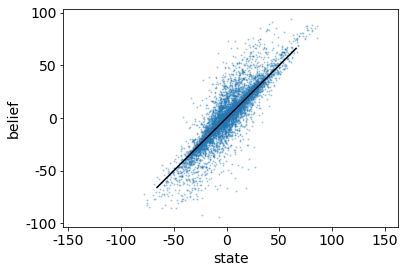

In [14]:
# pred=(cross_val_predict(LinearRegression(), Y[mask][:, [4]], Y[mask][:, 6]))
plt.scatter(Y[mask][:, [4]], Y[mask][:, 6],s=1, alpha=0.3)
plt.axis('equal')
plt.plot([-66,66],[-66,66],'k')
plt.xlabel(' eye')
plt.ylabel('true state')
plt.show()
# pred=(cross_val_predict(LinearRegression(), Y[mask][:, [4]], B[mask][:, 6]))
plt.scatter(Y[mask][:, [4]], B[mask][:, 6],s=1, alpha=0.3)
plt.axis('equal')
plt.plot([-66,66],[-66,66],'k')
plt.xlabel('eye')
plt.ylabel('belief')
plt.show()

plt.scatter(Y[mask][:, [6]], B[mask][:, 6],s=1, alpha=0.3)
plt.axis('equal')
plt.plot([-66,66],[-66,66],'k')
plt.xlabel('state')
plt.ylabel('belief')



## sanity check

make sure belief is making sense.

distributions of distance of belief/eye/state to the true target simlar.
eye stop distance is longer. 

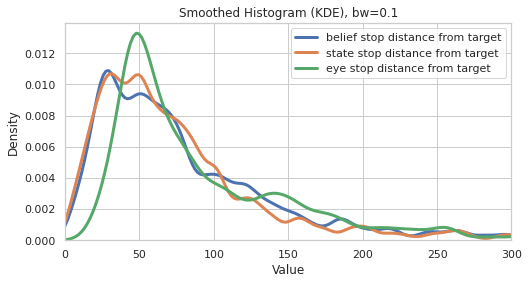

In [367]:
# load stops

i=0
belief_stop_dist=[]
state_stop_dist=[]
eye_stop_dist=[]
target_location=[]

while i<len(eval(m)['m53s31Ydownsampled_belief']):

    # belief
    bl,bf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]
    a,b=last_nonnan(bl), last_nonnan(bf)
    lastind=min(a,b)

    # state
    sl,sf=eval(m)['m53s31Ydownsampled'][i][1][:, 12], eval(m)['m53s31Ydownsampled'][i][1][:, 13]
    a,b=last_nonnan(sl), last_nonnan(sf)
    lastind=min(lastind,min(a,b))

    # eye
    hor_theta, ver_theta=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 4], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 5]
    ef, el=eye2world(hor_theta, ver_theta)
    a,b=last_nonnan(sl), last_nonnan(sf)
    lastind=min(lastind,min(a,b))


    belief_stop_dist.append((bl[lastind]**2+bf[lastind]**2)**0.5)
    state_stop_dist.append((sl[lastind]**2+sf[lastind]**2)**0.5)
    eye_stop_dist.append((ef[lastind]**2+el[lastind]**2)**0.5)
    target_location.append([sl[0],sf[1]])

    i+=1

# a histogram to see distance distribution
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.kdeplot(belief_stop_dist, fill=False,lw=3, bw=0.1, label='belief stop distance from target')
sns.kdeplot(state_stop_dist, fill=False,lw=3,  bw=0.1, label='state stop distance from target')
sns.kdeplot(np.clip(eye_stop_dist,0,350), lw=3, fill=False, bw=0.1, label='eye stop distance from target')

plt.xlim(0,300)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Smoothed Histogram (KDE), bw=0.1")
plt.legend()


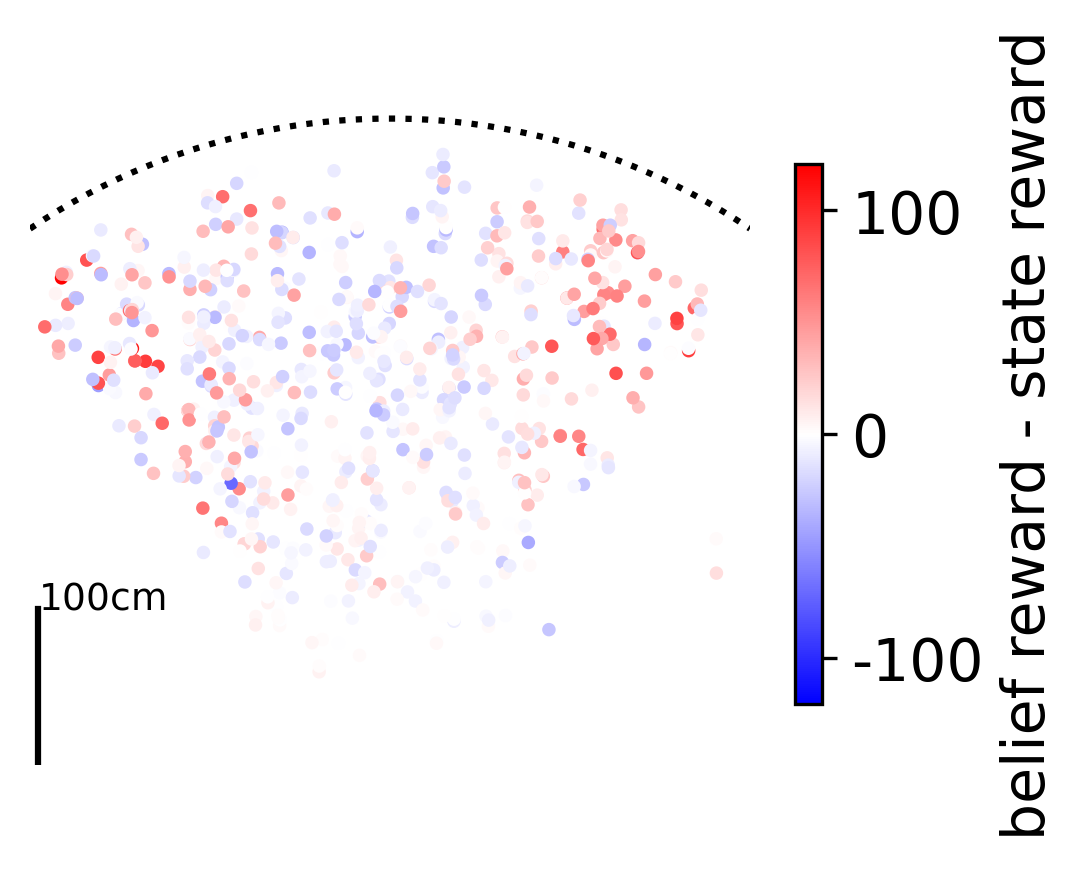

In [154]:
# a scatter plot to see the target location distribution and (d_belief, d_state)

fig, ax = overheadbase(figsize=(3,3))
bsdiff=[a-b for a,b in zip(belief_stop_dist, state_stop_dist)]
target_location=np.array(target_location)

vm=np.max(np.abs(bsdiff))
cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=bsdiff, cmap='bwr', vmin=-vm, vmax=vm)
cbar = fig.colorbar(cax,shrink=0.6, label='belief reward - state reward')



Text(0.5, 1.0, 'cbar centered at 65cm')

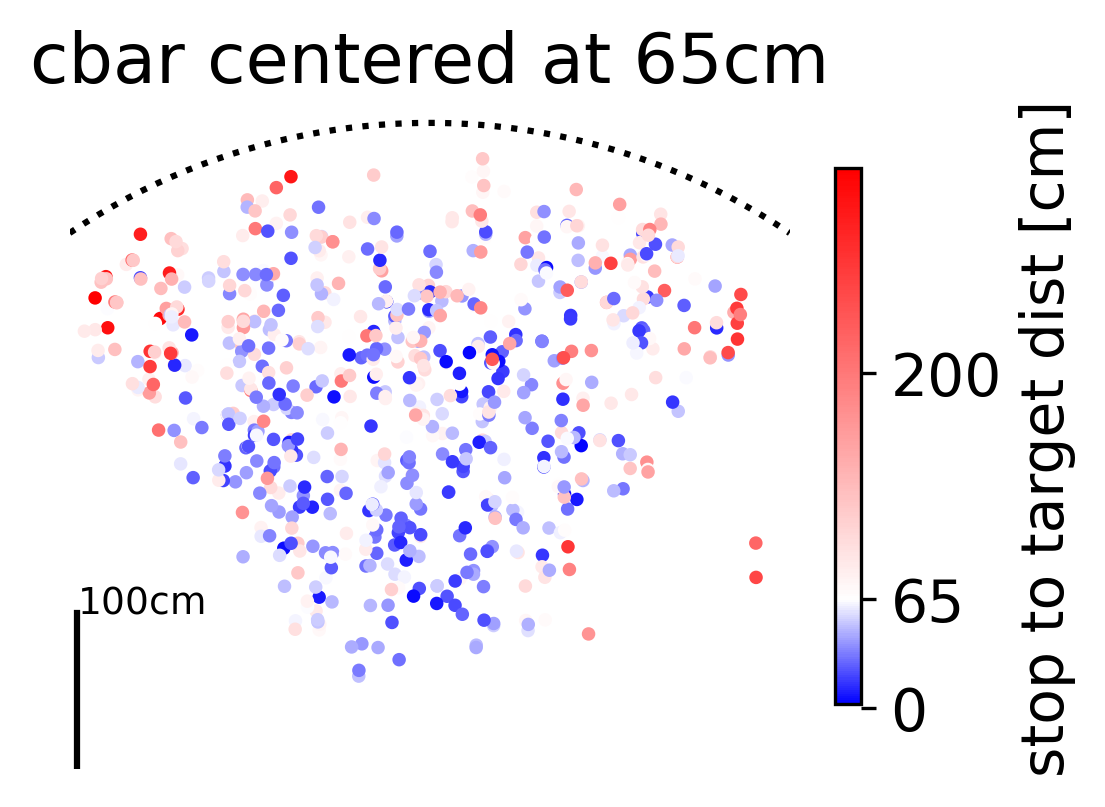

In [173]:
# state stop dist to target

fig, ax = overheadbase(figsize=(3,3))

target_location=np.array(target_location)

vm=np.max(np.abs(state_stop_dist))

norm=getcbarnorm(min(state_stop_dist), 65, max(state_stop_dist))

cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=state_stop_dist, cmap='bwr', norm=norm)
cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
# cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
cbar.ax.yaxis.set_ticks([0,65,200])
cbar.ax.yaxis.set_ticklabels([0,65,200])
ax.set_title('cbar centered at 65cm')


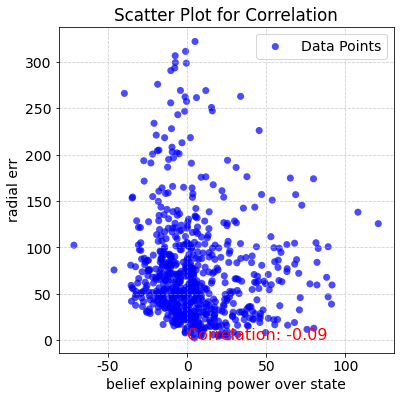

In [183]:
# radial err vs belief explaining corr
x,y=np.asarray(bsdiff), np.asarray(state_stop_dist)
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.scatter(x, y, color='b', label='Data Points', edgecolors='none', s=50, alpha=0.7)
plt.xlabel('belief explaining power over state')
plt.ylabel('radial err')
plt.title('Scatter Plot for Correlation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
correlation_coefficient = np.corrcoef(x, y)[0, 1]
plt.text(0.1, 1.5, f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='red')
plt.show()


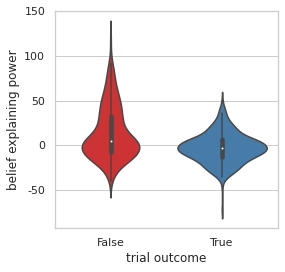

In [206]:

x,y=np.asarray(bsdiff), np.asarray(belief_stop_dist)

plt.figure(figsize=(4, 4))

data = {
    "trial success": y<65,
    "belief explaining power": x,
}

# Create a Seaborn violin plot
sns.violinplot(x="trial success", y="belief explaining power", data=data, palette="Set1")

# Add labels and title
plt.xlabel("trial outcome")
plt.ylabel("belief explaining power")


# Show the plot
plt.show()


state vs belief at getting rewards. 
similar. in this session, state get slightly more.

In [100]:
# load stops
from scipy.stats import multivariate_normal

i=0
belief_reward=[]
state_reward=[]

while i<len(eval(m)['m53s31Ydownsampled_belief']):

    # belief
    bl,bf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]
    sxx,syy, sxy=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 15], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 16],eval(m)['m53s31Ydownsampled_belief'][i][1][:, 17]

    a,b=last_nonnan(bl), last_nonnan(bf)
    lastind=min(a,b)

    # state
    sl,sf=eval(m)['m53s31Ydownsampled'][i][1][:, 12], eval(m)['m53s31Ydownsampled'][i][1][:, 13]
    a,b=last_nonnan(sl), last_nonnan(sf)
    lastind=min(lastind,min(a,b))

    # # eye
    # hor_theta, ver_theta=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 4], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 5]
    # ef, el=eye2world(hor_theta, ver_theta)
    # a,b=last_nonnan(sl), last_nonnan(sf)
    # lastind=min(lastind,min(a,b))


    sd=(sl[lastind]**2+sf[lastind]**2)**0.5
    if sd<65: 
        state_reward.append(1)
    else:
        state_reward.append(0)

    point=np.array([bl[lastind],bf[lastind]])
    sigma=np.array([[sxx[lastind], sxy[lastind]], [sxy[lastind], syy[lastind]]])
    mvn = multivariate_normal(mean=np.array([0.,0.]), cov=sigma)
    probability = mvn.pdf(point)
    belief_reward.append(probability)

    i+=1


## find what influence the belief-eye and state-eye correlation

In [223]:
Y_=eval(m)['m53s31Ydownsampled']
B_=eval(m)['m53s31Ydownsampled_belief']
trial_idces, Y = zip(*Y_)
Y = np.vstack(Y)
trial_idces, B = zip(*B_)
B = np.vstack(B)

### trial time

belief is slightly better at the end, compare to states

In [235]:
trial_time=[]
for i, d in Y_:
    trial_time.append(np.arange(0,len(d),1))
trial_time=np.hstack(trial_time)

(11051,)

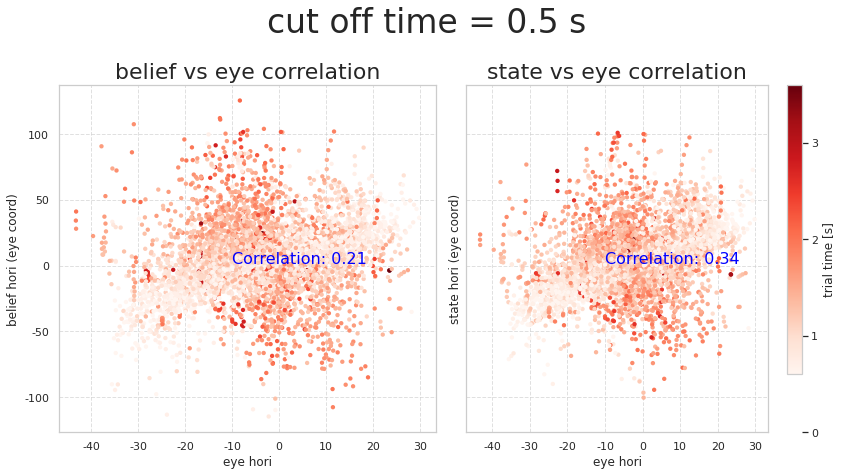

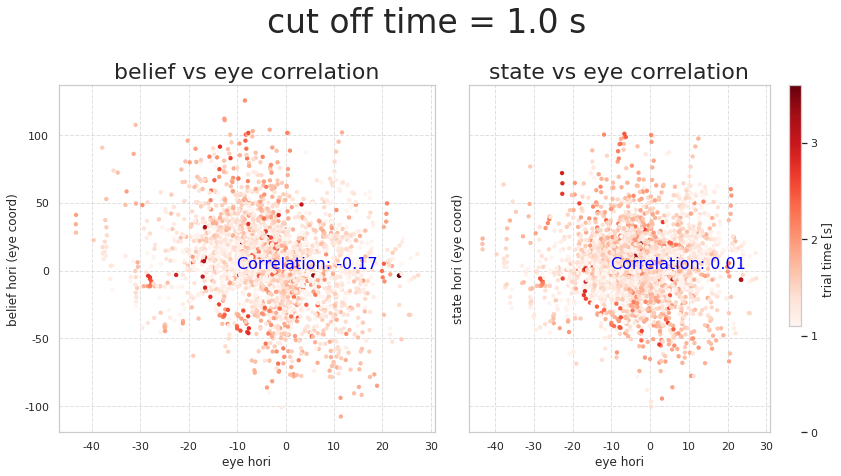

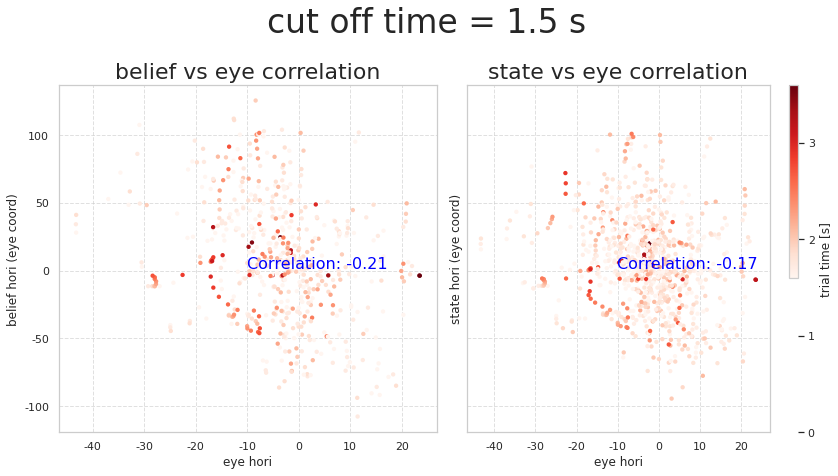

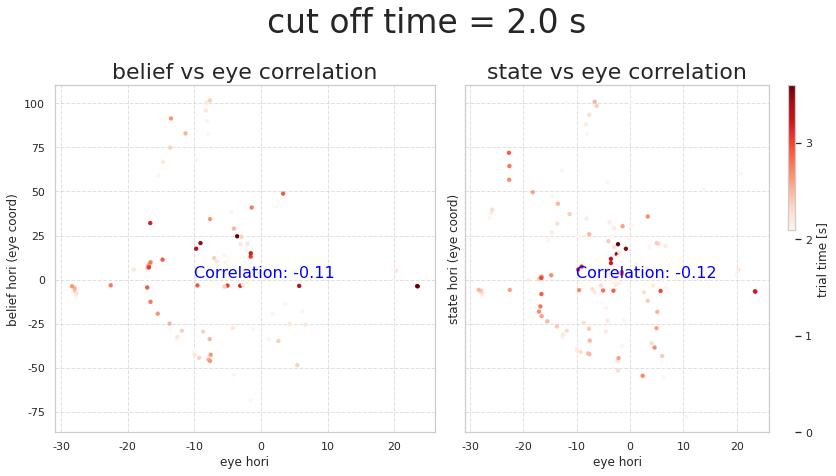

In [292]:
s=19
textxy=[-10.1, 1.5]

for cutoff in np.arange(5,25,5):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (eye coord)'
    x,y=Y[:,4],B[:,6]
    c=trial_time
    x,y=x[c>cutoff],y[c>cutoff]
    c=c[c>cutoff]
    ax=axs[0]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=s, alpha=1)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'
    ylabel='state hori (eye coord)'
    y=Y[:,6]
    c=trial_time
    y=y[c>cutoff]
    c=c[c>cutoff]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=s, alpha=1)
    cbar = fig.colorbar(cax,shrink=1, label='trial time [s]')
    cbar.ax.yaxis.set_ticks(np.arange(0,40,10))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,4,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'cut off time = {cutoff/10} s', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


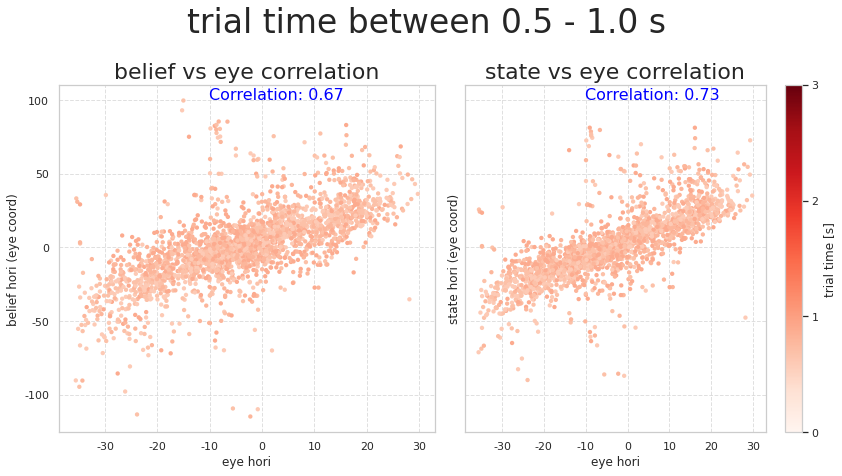

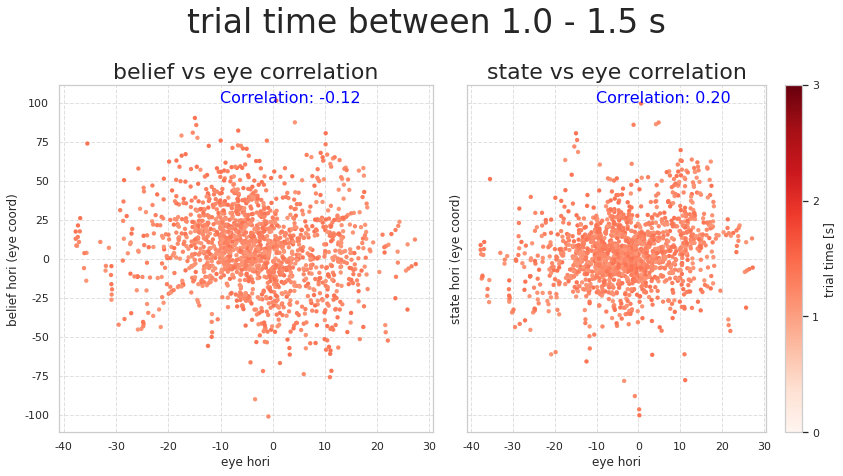

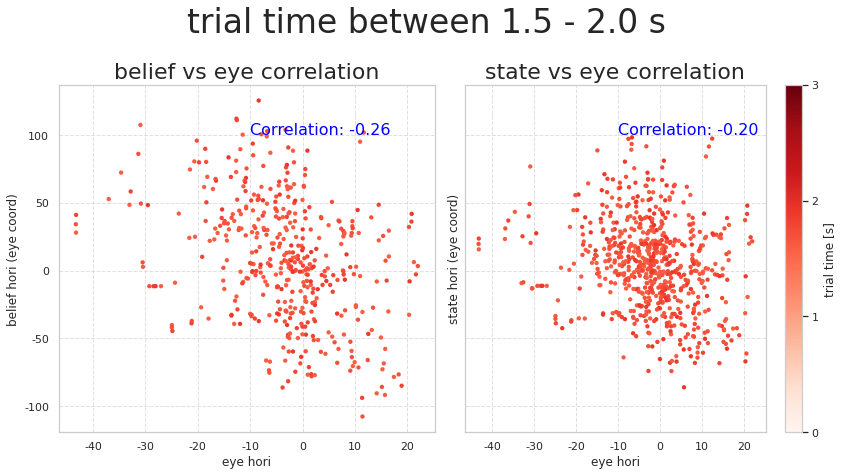

In [363]:
size=19
textxy=[-10.1, 100.5]
bins=np.arange(5,25,5)
for s,e in zip(bins[:-1], bins[1:]):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (eye coord)'
    x,y=Y[:,4],B[:,6]
    c=trial_time
    x,y=x[(s<c)&(c<e)],y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[0]
    norm=getcbarnorm(0,15,30)
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'
    ylabel='state hori (eye coord)'
    y=Y[:,6]
    c=trial_time
    y=y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)
    cbar = fig.colorbar(cax,shrink=1, label='trial time [s]')
    cbar.ax.yaxis.set_ticks(np.arange(0,40,10))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,4,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'trial time between {s/10} - {e/10} s', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


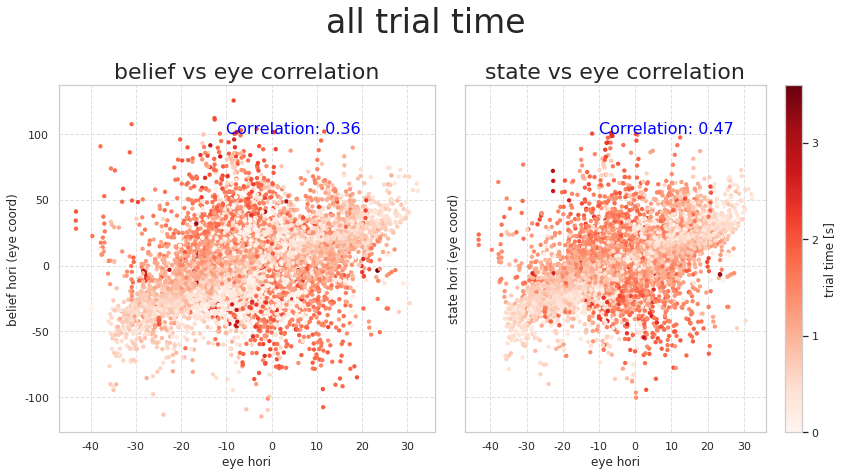

In [322]:
size=19
textxy=[-10.1, 100.5]
c=trial_time

fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

xlabel='eye hori'
ylabel='belief hori (eye coord)'
x,y=Y[:,4],B[:,6]
ax=axs[0]
cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('belief vs eye correlation', fontsize=22)
# plt.legend()
ax.grid(True, linestyle='--', alpha=0.6)
fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


xlabel='eye hori'
ylabel='state hori (eye coord)'
y=Y[:,6]
ax=axs[1]
cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1)
cbar = fig.colorbar(cax,shrink=1, label='trial time [s]')
cbar.ax.yaxis.set_ticks(np.arange(0,40,10))
cbar.ax.yaxis.set_ticklabels(np.arange(0,4,1))

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('state vs eye correlation', fontsize=22)
# plt.legend()
ax.grid(True, linestyle='--', alpha=0.6)
fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

fig.suptitle(f'all trial time', fontsize=33, y=1.1)
plt.tight_layout()
plt.show()


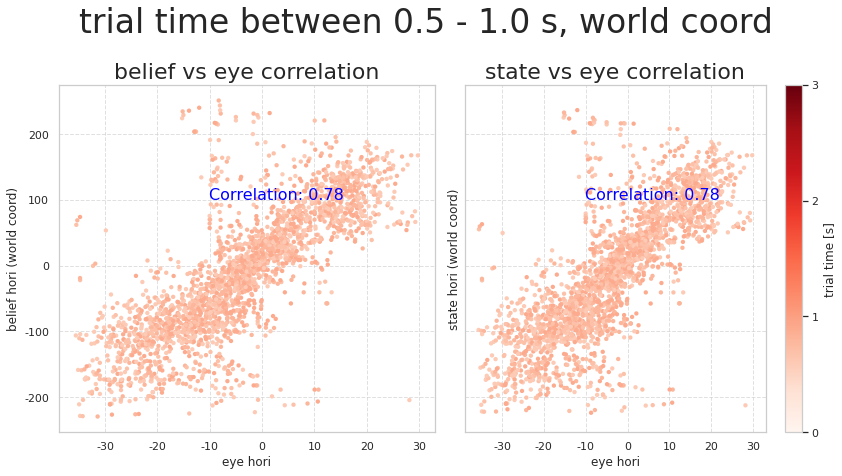

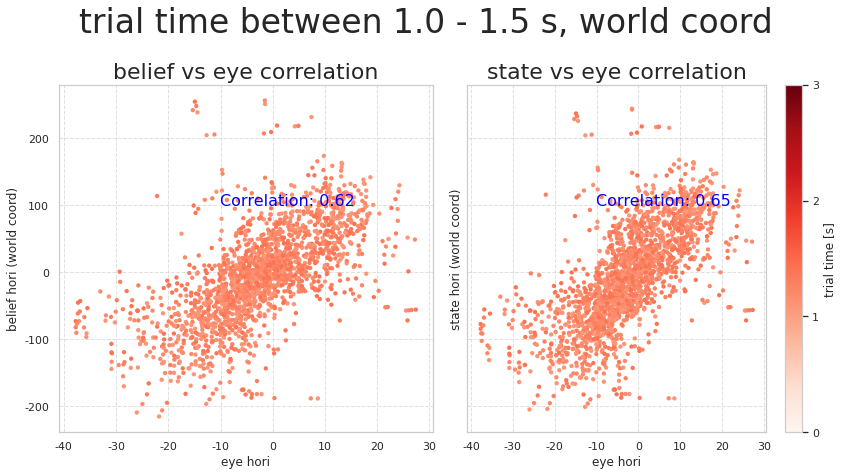

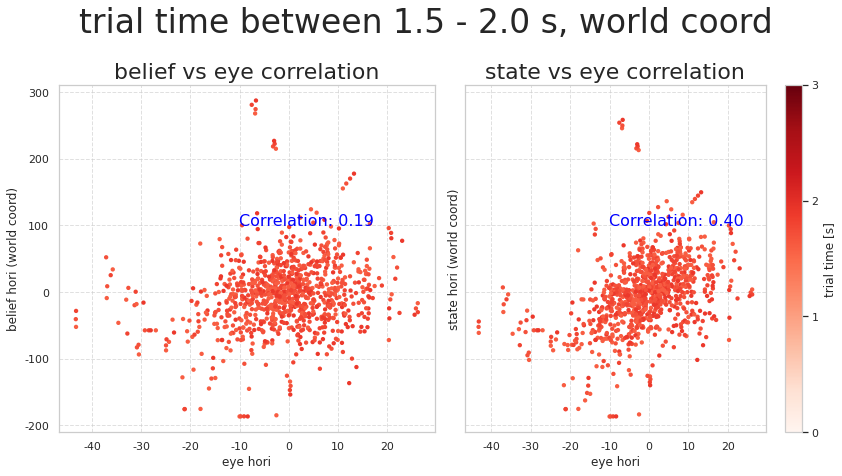

In [342]:
size=19
textxy=[-10.1, 100.5]
bins=np.arange(5,25,5)
for s,e in zip(bins[:-1], bins[1:]):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (world coord)'
    x,y=Y[:,4],B[:,8]
    hor,ver=Y[:,4], Y[:,5]
    # _,x=eye2world(hor,ver)
    c=trial_time
    x,y=x[(s<c)&(c<e)],y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[0]
    norm=getcbarnorm(0,15,30)
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'
    ylabel='state hori (world coord)'
    y=Y[:,12]
    c=trial_time
    y=y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)
    cbar = fig.colorbar(cax,shrink=1, label='trial time [s]')
    cbar.ax.yaxis.set_ticks(np.arange(0,40,10))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,4,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'trial time between {s/10} - {e/10} s, world coord', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


### distance traveled

simlar as time. at first, state has high correlation.
when time/distance grows, belief has better correlation.
but since not all trials are long, on average belief fits slightly worse then states.

i think this is understandable.
the results suggest our model did not capture the entire dynamic.
the current model focus more on the stops and did its job explaining the actions directly relavent to rewards.
however, the model did not well explain the early part of the trial, and how previous actions influence next actions.
this is understandble because the error accumulates when we trace back in time.
we also made some strong assumptions which may cause this. eg, monkey is not a kalman filter, and monkey's cost may not be linear (can push agist boundry.)

In [305]:
trial_dist_traveled=[]
for i, d in Y_:
    trial_dist_traveled.append(np.cumsum(d[:,13])*0.1)
trial_dist_traveled=np.hstack(trial_dist_traveled)


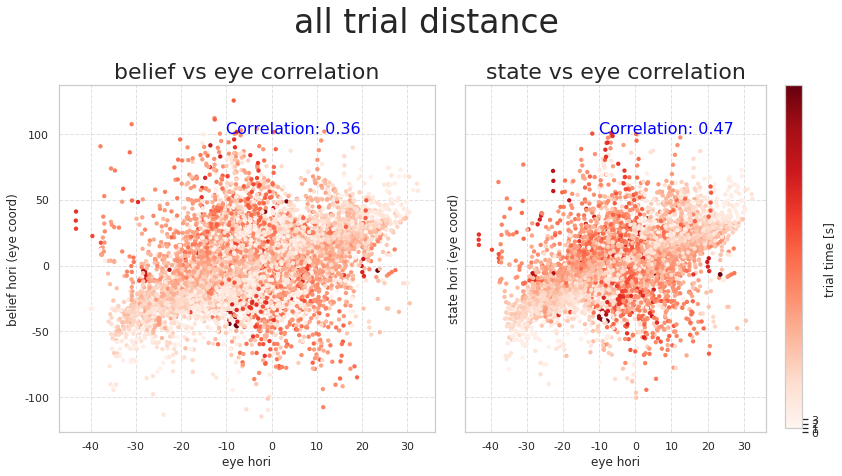

In [323]:
size=19
textxy=[-10.1, 100.5]
c=trial_dist_traveled

fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

xlabel='eye hori'
ylabel='belief hori (eye coord)'
x,y=Y[:,4],B[:,6]
ax=axs[0]
cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('belief vs eye correlation', fontsize=22)
# plt.legend()
ax.grid(True, linestyle='--', alpha=0.6)
fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


xlabel='eye hori'
ylabel='state hori (eye coord)'
y=Y[:,6]
ax=axs[1]
cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1)
cbar = fig.colorbar(cax,shrink=1, label='trial time [s]')
cbar.ax.yaxis.set_ticks(np.arange(0,40,10))
cbar.ax.yaxis.set_ticklabels(np.arange(0,4,1))

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('state vs eye correlation', fontsize=22)
# plt.legend()
ax.grid(True, linestyle='--', alpha=0.6)
fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

fig.suptitle(f'all trial distance', fontsize=33, y=1.1)
plt.tight_layout()
plt.show()


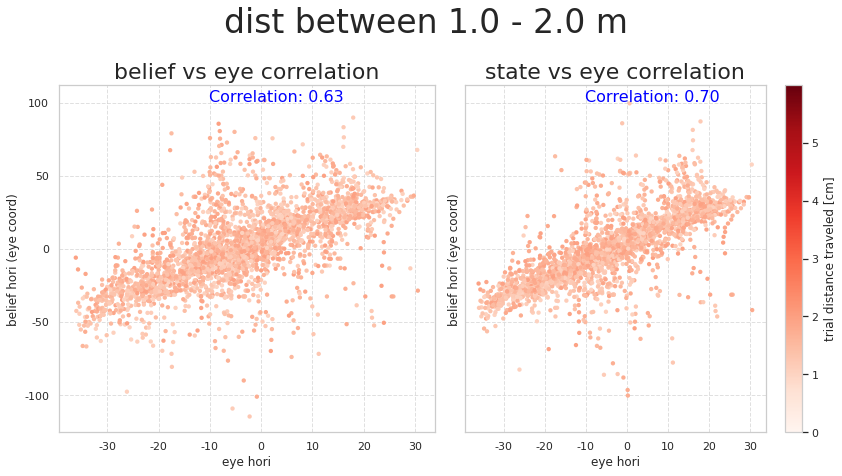

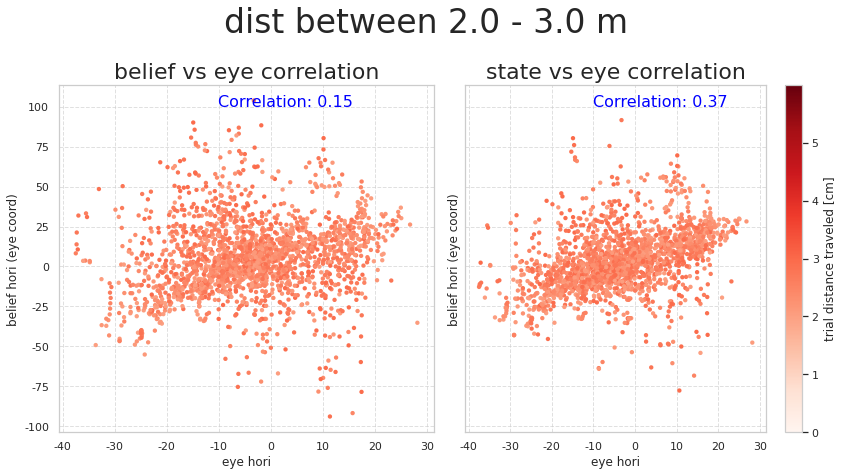

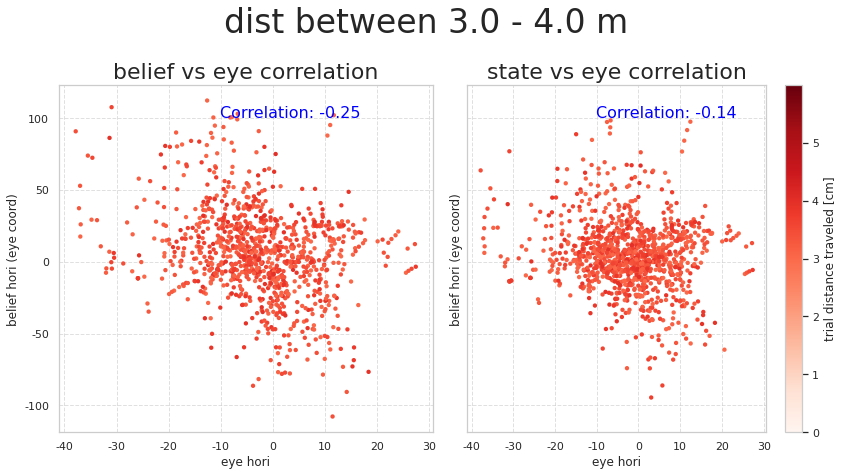

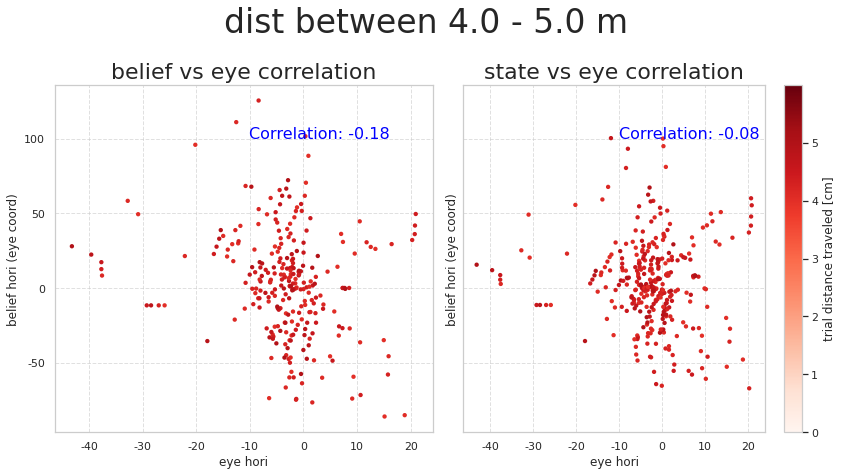

In [335]:
size=19
textxy=[-10.1, 100.5]
bins=np.arange(100,600,100)

for s,e in zip(bins[:-1], bins[1:]):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (eye coord)'
    x,y=Y[:,4],B[:,6]
    c=trial_dist_traveled
    x,y=x[(s<c)&(c<e)],y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    norm=getcbarnorm(0,300,600)
    ax=axs[0]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'

    y=Y[:,6]
    c=trial_dist_traveled
    y=y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)
    cbar = fig.colorbar(cax,shrink=1, label='trial distance traveled [cm]')
    cbar.ax.yaxis.set_ticks(np.arange(0,600,100))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,6,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'dist between {s/100} - {e/100} m', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


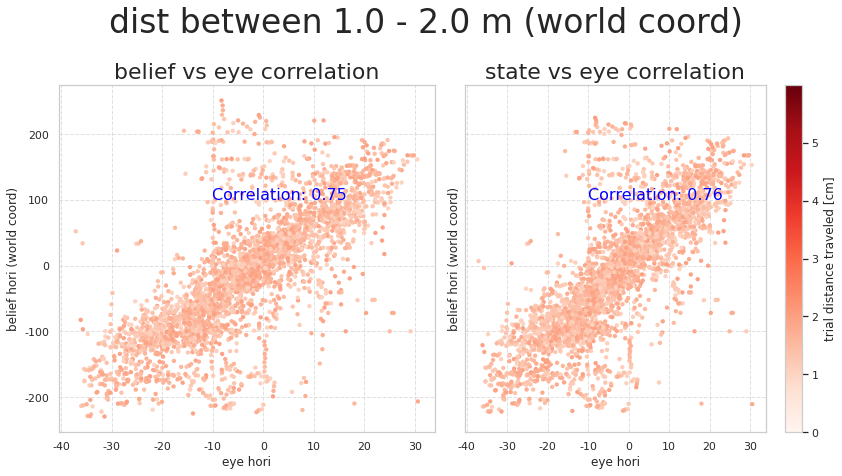

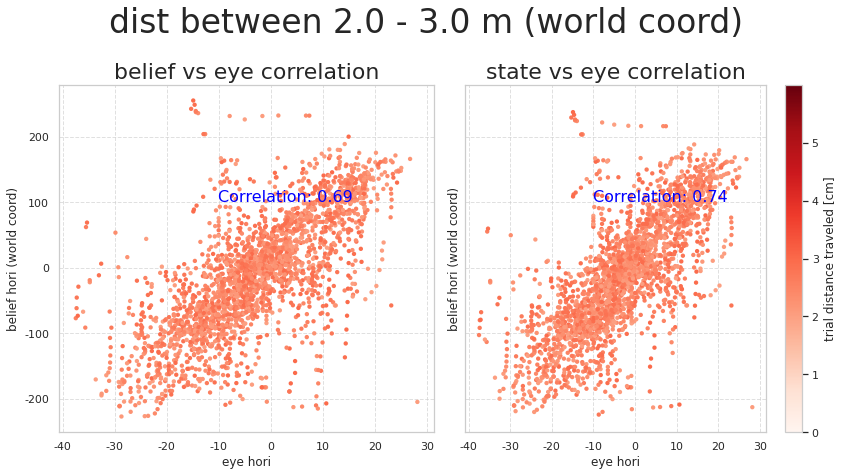

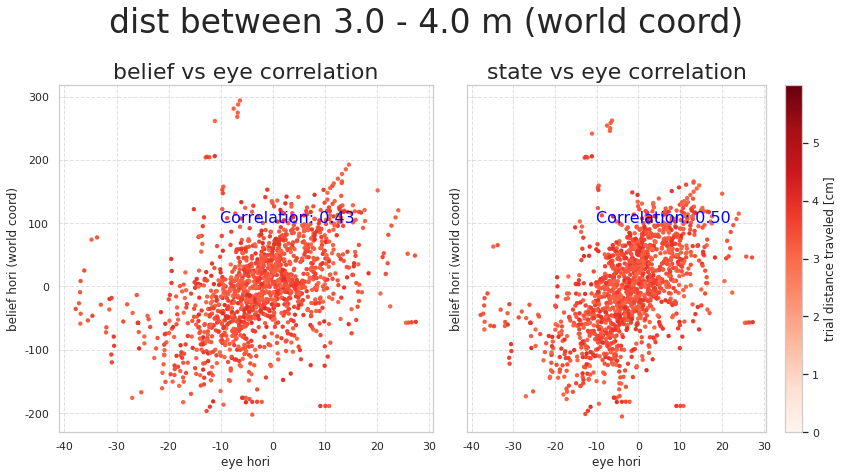

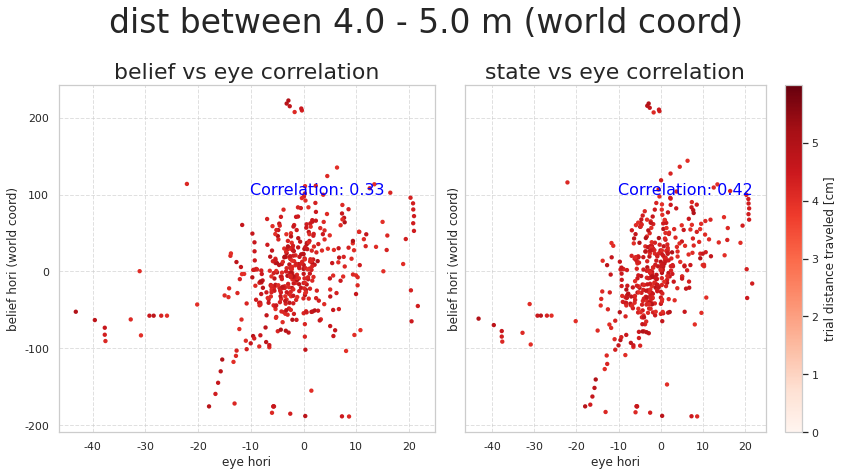

In [343]:
size=19
textxy=[-10.1, 100.5]
bins=np.arange(100,600,100)

for s,e in zip(bins[:-1], bins[1:]):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (world coord)'
    x,y=Y[:,4],B[:,8]
    hor,ver=Y[:,4], Y[:,5]
    # _,x=eye2world(hor,ver)
    c=trial_dist_traveled
    x,y=x[(s<c)&(c<e)],y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    norm=getcbarnorm(0,300,600)
    ax=axs[0]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'
    y=Y[:,12]
    c=trial_dist_traveled
    y=y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)
    cbar = fig.colorbar(cax,shrink=1, label='trial distance traveled [cm]')
    cbar.ax.yaxis.set_ticks(np.arange(0,600,100))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,6,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'dist between {s/100} - {e/100} m (world coord)', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


### location on screen

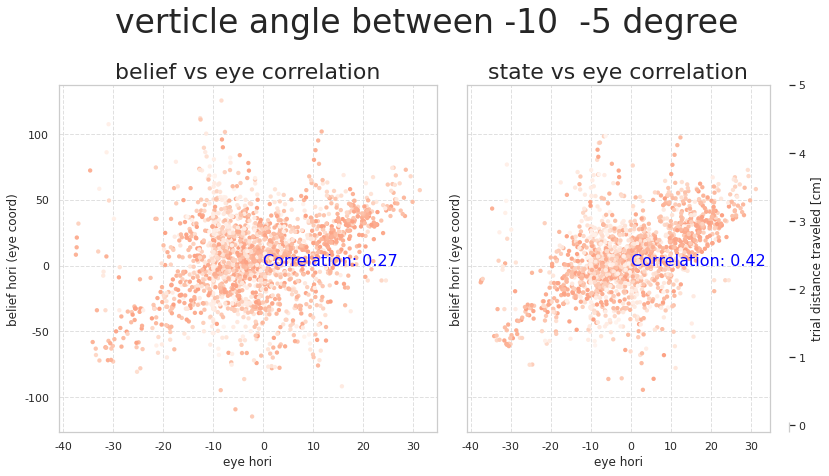

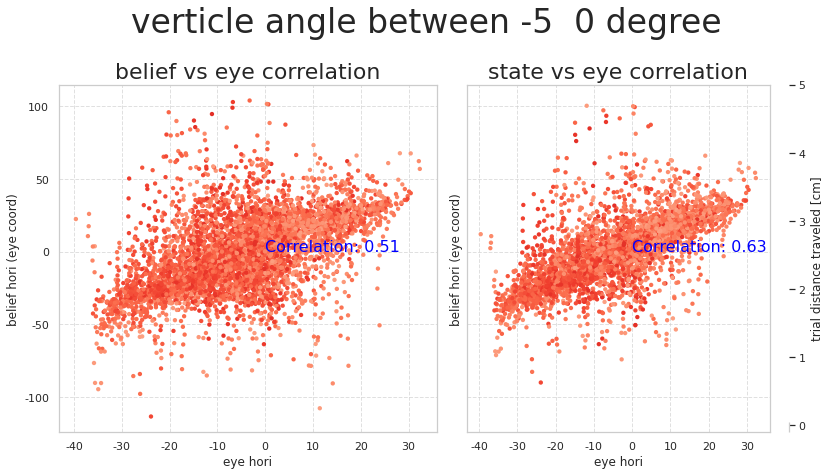

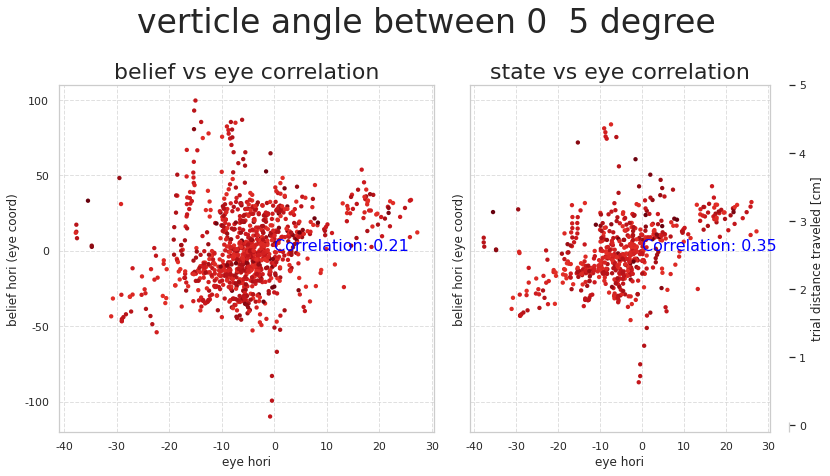

In [360]:
size=19
textxy=[0,0]
bins=np.arange(-10,10,5)

for s,e in zip(bins[:-1], bins[1:]):

    fig,axs=plt.subplots(1,2,figsize=(12, 6), sharex=True, sharey=True)

    xlabel='eye hori'
    ylabel='belief hori (eye coord)'
    x,y=Y[:,4],B[:,6]
    c=Y[:,5]
    x,y=x[(s<c)&(c<e)],y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    norm=getcbarnorm(bins[0],np.mean(bins),bins[-1])
    ax=axs[0]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('belief vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')


    xlabel='eye hori'

    y=Y[:,6]
    c=Y[:,5]
    y=y[(s<c)&(c<e)]
    c=c[(s<c)&(c<e)]
    ax=axs[1]
    cax=ax.scatter(x, y,c=c, cmap='Reds', label='Data Points', edgecolors='none', s=size, alpha=1, norm=norm)
    cbar = fig.colorbar(cax,shrink=1, label='trial distance traveled [cm]')
    cbar.ax.yaxis.set_ticks(np.arange(0,600,100))
    cbar.ax.yaxis.set_ticklabels(np.arange(0,6,1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('state vs eye correlation', fontsize=22)
    # plt.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    fixnan=lambda data: np.nan_to_num(data, nan=np.nanmedian(data))
    correlation_coefficient = np.corrcoef(fixnan(x), fixnan(y))[0, 1]
    ax.text(textxy[0],textxy[1], f'Correlation: {correlation_coefficient:.2f}', fontsize=16, color='blue')

    fig.suptitle(f'verticle angle between {s}  {e} degree', fontsize=33, y=1.1)
    plt.tight_layout()
    plt.show()


### side vs center target

### trial likelihood distribution

# recycle

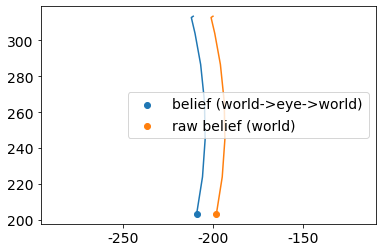

In [17]:
# i+=1

fig,ax=plt.subplots()

# belief
hor_theta, ver_theta=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 6], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 7]

# raw belief (world) # convert raw belief to eye
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]
hor_theta=-np.rad2deg(np.arctan2(-wl, np.sqrt(wf**2 + 10**2)))
ver_theta = -np.rad2deg(np.arctan2(10, (wl**2+wf**2)**0.5))

bwf, bwl=eye2world(hor_theta, ver_theta)

# eye
hor_theta, ver_theta=eval(m)['m53s31Ydownsampled'][i][1][:, 4], eval(m)['m53s31Ydownsampled'][i][1][:, 5]
ewf, ewl=eye2world(hor_theta, ver_theta)

# raw belief
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]


validinds = (~np.isnan(bwf)) &(~np.isnan(bwl)) & (~np.isnan(ewf))& (~np.isnan(ewl))

ax.plot(bwl[validinds],bwf[validinds])
ax.scatter(bwl[validinds][-1],bwf[validinds][-1], label='belief (world->eye->world)')
# ax.plot(ewl[validinds],ewf[validinds], label='eye')
ax.plot(wl[validinds]+11,wf[validinds])
ax.scatter(wl[validinds][-1]+11,wf[validinds][-1], label='raw belief (world)')


plt.legend()
plt.axis('equal')
plt.show()


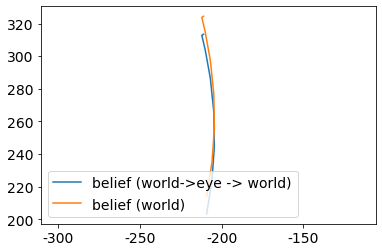

In [18]:
fig,ax=plt.subplots()


# raw belief (world)
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]
# convert raw belief to eye
hor=-np.rad2deg(np.arctan2(-wl, np.sqrt(wf**2 + 10**2)))
ver = -np.rad2deg(np.arctan2(10, (wl**2+wf**2)**0.5))
bwf, bwl=eye2world(hor, ver)

ax.plot(bwl, bwf, label='belief (world->eye -> world)')

# get the computed belief tar in eye corod
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]# # # 
ax.plot(wl,wf+11, label='belief (world)')


plt.legend()
plt.axis('equal')
plt.show()
i+=1

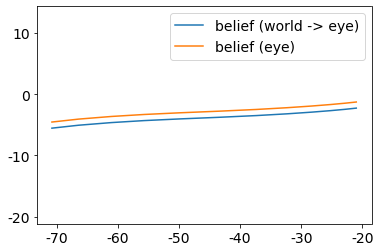

In [19]:
i+=1

fig,ax=plt.subplots()


# raw belief (world)
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 8], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 9]
# convert raw belief to eye
hor=-np.rad2deg(np.arctan2(-wl, np.sqrt(wf**2 + 10**2)))
ver = -np.rad2deg(np.arctan2(10, (wl**2+wf**2)**0.5))
ax.plot(hor,ver, label='belief (world -> eye)')

# get the computed belief tar in eye corod
wl,wf=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 6], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 7]
ax.plot(hor,ver+1, label='belief (eye)')


plt.legend()
plt.axis('equal')
plt.show()

In [20]:
Y_=eval(m)['m53s31Ydownsampled']
B_=eval(m)['m53s31Ydownsampled_belief']
X_=eval(m)['m53s31Xdownsampled']['PPC']

len(X_), len(B_), len(Y_)

trial_idces, X = zip(*X_)
X = np.vstack(X)
trial_idces, Y = zip(*Y_)
Y = np.vstack(Y)
trial_idces, B = zip(*B_)
B = np.vstack(B)


mask = (~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression horizontal',np.mean(cross_val_score(LinearRegression(), Y[mask][:, [4]], Y[mask][:, 6])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [4]], B[mask][:, 6])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7]))
print('linear regression vertical', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [5]], Y[mask][:, 7])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [5]], B[mask][:, 7])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7])) &(~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression both', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [4,5]], Y[mask][:, [6,7]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [4,5]], B[mask][:, [6,7]])))



mask = (~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression horizontal',np.mean(cross_val_score(LinearRegression(), Y[mask][:, 6], Y[mask][:, [4]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, 6], B[mask][:, [4]])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7]))
print('linear regression vertical', np.mean(cross_val_score(LinearRegression(), Y[mask][:, 7], Y[mask][:, [5]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, 7], B[mask][:, [5]])))
mask = (~np.isnan(Y[:, 7])) & (~np.isnan(B[:, 7])) &(~np.isnan(Y[:, 6])) & (~np.isnan(B[:, 6]))
print('linear regression both', np.mean(cross_val_score(LinearRegression(), Y[mask][:, [6,7]], Y[mask][:, [4,5]])), np.mean(cross_val_score(LinearRegression(), B[mask][:, [6,7]], B[mask][:, [4,5]])))



linear regression horizontal 0.3488763639362703 0.15801833067666243
linear regression vertical 0.09623288633479521 0.07929697962301589
linear regression both 0.3744588478303449 0.17638733020239689
linear regression horizontal nan nan
linear regression vertical nan nan
linear regression both 0.34795861498837305 0.16319530492905904


In [21]:
hor_theta, ver_theta=eval(m)['m53s31Ydownsampled_belief'][i][1][:, 6], eval(m)['m53s31Ydownsampled_belief'][i][1][:, 7]
hor_theta, ver_theta

(array([-19.42224503, -24.03164101, -29.22955704, -35.14985275,
        -42.05924988, -50.08504105, -58.24942017, -58.75541687,
        -54.00003433, -48.63380051, -43.22804642, -36.71453857]),
 array([-2.2765792 , -2.46995036, -2.68982168, -2.93732544, -3.21004911,
        -3.49633116, -3.77779379, -4.03774992, -4.31708197, -4.64119266,
        -5.07386074, -5.55230083]))